# Pump it up - Data mining the water table
#### https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

### Balazs Balogh - 2019. 12.

In [1]:
"""
Import the packages.
"""

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import tree, ensemble, metrics, svm
from xgboost import XGBClassifier
from xgboost import *

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', 50)

In [2]:
"""
Import the datasets, concatenate them, and encode the 'status_group' column to numerical for the ML model.
"""

X_train = pd.read_csv('https://raw.githubusercontent.com/budapestpy-workshops/workshops/master/09_pump_it_up/Training_set_values.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/budapestpy-workshops/workshops/master/09_pump_it_up/Training_set_labels.csv')

data = X_train.merge(y_train, on='id')

label_dict = {"functional" : 2, "functional needs repair" : 1, "non functional" : 0}
data["label"] = data["status_group"].map(label_dict)

In [3]:
"""
Check out the data.
"""

data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,label
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,2
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 42 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [5]:
data.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,label
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,1.158838
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.949794
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,2.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,2.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2.000000


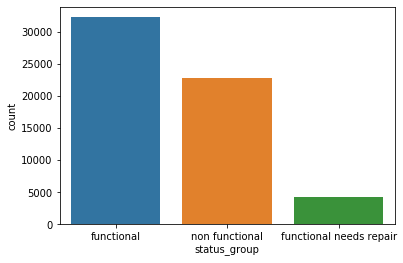

In [6]:
"""
Let's visualise the status groups which we have to predict. The data is imbalanced.

functional                 32259
non functional             22824
functional needs repair     4317

The 54% of the values is functional, so this could be the baseline model. If we predict every pump to functional, we get a 54%
accuracy.
"""

sns.countplot(data['status_group'])

# Feautre engineering and EDA

## Deal with NaN / 0 values first.

In [7]:
"""
Overall investigating first the numeric type columns.
Create two dataframes one for the numerical columns, and one for the object type.
"""

data_numeric = data.select_dtypes(include=['float64','int64']).drop(['label', 'id'], axis=1)
data_object = data.select_dtypes(include=['object'])

In [8]:
"""
The numeric columns doesn't have any NaNs.
If we consider 0 = NaN, here's how the numeric columns look like.
"""

for i in data_numeric.columns:
    print(i, '| {:.1%}'.format(data[i].loc[data[i] == 0].count() / len(data)), 'is zero |' ,type(data[i][0]), '|',
    data[i].nunique(), 'unique values |', data['id'].loc[data[i] == 0].count(), 'zero count.')

amount_tsh | 70.1% is zero | <class 'numpy.float64'> | 98 unique values | 41639 zero count.
gps_height | 34.4% is zero | <class 'numpy.int64'> | 2428 unique values | 20438 zero count.
longitude | 3.1% is zero | <class 'numpy.float64'> | 57516 unique values | 1812 zero count.
latitude | 0.0% is zero | <class 'numpy.float64'> | 57517 unique values | 0 zero count.
num_private | 98.7% is zero | <class 'numpy.int64'> | 65 unique values | 58643 zero count.
region_code | 0.0% is zero | <class 'numpy.int64'> | 27 unique values | 0 zero count.
district_code | 0.0% is zero | <class 'numpy.int64'> | 20 unique values | 23 zero count.
population | 36.0% is zero | <class 'numpy.int64'> | 1049 unique values | 21381 zero count.
construction_year | 34.9% is zero | <class 'numpy.int64'> | 55 unique values | 20709 zero count.


In [9]:
"""
The same for the object columns.
"""

for i in data_object.columns:
    print(i, '|', '{:.1%}'.format(np.mean(data[i].isnull())), 'nulls', '|' ,type(data[i][0]), '|',
    data[i].nunique(), 'unique values')

date_recorded | 0.0% nulls | <class 'str'> | 356 unique values
funder | 6.1% nulls | <class 'str'> | 1897 unique values
installer | 6.2% nulls | <class 'str'> | 2145 unique values
wpt_name | 0.0% nulls | <class 'str'> | 37400 unique values
basin | 0.0% nulls | <class 'str'> | 9 unique values
subvillage | 0.6% nulls | <class 'str'> | 19287 unique values
region | 0.0% nulls | <class 'str'> | 21 unique values
lga | 0.0% nulls | <class 'str'> | 125 unique values
ward | 0.0% nulls | <class 'str'> | 2092 unique values
public_meeting | 5.6% nulls | <class 'bool'> | 2 unique values
recorded_by | 0.0% nulls | <class 'str'> | 1 unique values
scheme_management | 6.5% nulls | <class 'str'> | 12 unique values
scheme_name | 47.4% nulls | <class 'str'> | 2696 unique values
permit | 5.1% nulls | <class 'bool'> | 2 unique values
extraction_type | 0.0% nulls | <class 'str'> | 18 unique values
extraction_type_group | 0.0% nulls | <class 'str'> | 13 unique values
extraction_type_class | 0.0% nulls | <clas

In [10]:
"""
LATITUDE / LONGITUDE:
We can see that there are 1812 latitude / longitude combinations in the TRAIN set, where there are corrupted data. Fortunately
this is not much, compared to the overall 59.400 rows, so we can definitely impute them somehow, or delete them.
"""

print(data['id'].loc[(data['longitude'] == 0) & (data['latitude'] == -2.000000e-08)].count())
print(data['id'].loc[(data['longitude'] == 0) & (data['latitude'] != -2.000000e-08)].count())

1812
0


In [11]:
"""
Start with object columns.

'funder' has 1897 different values, and 6,1% of NaNs, we should compress them, 
making an 'other' column for values smaller 1300.
"""
print('Different values in \'funder\':', data['funder'].value_counts().count(), '\n')
print(data['funder'].value_counts().head(10))

Different values in 'funder': 1897 

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Name: funder, dtype: int64


In [12]:
"""
Continue with the 'installer' column. This has 6.2% of NaNs.
Looking at the top 10 rows, I could see a correlation with 'funder', so maybe we shouldn't use this, but I will do the
binning anyway.
"""

print('Different values in \'installer\':', data['installer'].value_counts().count(), '\n')
print(data['installer'].value_counts().head(10))

Different values in 'installer': 2145 

DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
Name: installer, dtype: int64


In [13]:
"""
'scheme_management' has 6.5% of NaNs. We can bin the 12 values to 6.
"""

print('Different values in \'scheme_management\':', data['scheme_management'].value_counts().count(), '\n')
print(data['scheme_management'].value_counts().head(10))

Different values in 'scheme_management': 12 

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Name: scheme_management, dtype: int64


In [14]:
"""
Object NaN handling:

Handling NaN's with binning 'funder' / 'installer' / 'scheme_management' column.
Filling in with the mode: 'subvillage' column, because it has only 0.6% of NaNs.
Filling with False: 'permit' and 'public_meeting'.
We won't deal with scheme_name, almost half of the values are NaN.
"""

def funder_binning(row):
    if row['funder'] == 'Government Of Tanzania':
        return 'gov'
    elif row['funder'] == 'Danida':
        return 'danida'
    elif row['funder'] == 'Hesawa':
        return 'hesawa'
    elif row['funder'] == 'Rwssp':
        return 'rwssp'
    elif row['funder'] == 'World Bank':
        return 'worldbank'
    else:
        return 'other'
    
def installer_binning(row):
    if row['installer'] == 'DWE':
        return 'dwe'
    elif row['installer'] == 'Government':
        return 'gov'
    elif row['installer'] == 'RWE':
        return 'rwe'
    elif row['installer'] == 'Commu':
        return 'commu'
    elif row['installer'] == 'DANIDA':
        return 'danida'
    else:
        return 'other'
    
def scheme_management_binning(row):
    if row['scheme_management'] == 'VWC':
        return 'vwc'
    elif row['scheme_management'] == 'WUG':
        return 'wug'
    elif row['scheme_management'] == 'Water authority':
        return 'water authority'
    elif row['scheme_management'] == 'WUA':
        return 'wua'
    elif row['scheme_management'] == 'Water Board':
        return 'water board'
    else:
        return 'other'
    
data['funder'] = data.apply(lambda row: funder_binning(row), axis=1)
data['installer'] = data.apply(lambda row: installer_binning(row), axis=1)
data['scheme_management'] = data.apply(lambda row: scheme_management_binning(row), axis=1)

data['subvillage'] = data['subvillage'].fillna(data['subvillage'].mode().iloc[0])

data['public_meeting'].fillna(False, inplace=True)
data['permit'].fillna(False, inplace=True)

In [15]:
"""
Numeric NaN handling.

Start with the 'construction_year' column
"""

data['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [16]:
"""
Make a binning for the 'construction_year'.
"""

def construction_year_binning(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
data['construction_year'] = data.apply(lambda row: construction_year_binning(row), axis=1)

In [17]:
data['construction_year'].sample(5)

23472        10s
23694    unknown
35018    unknown
22264        00s
49726    unknown
Name: construction_year, dtype: object

In [18]:
"""
Only 'scheme_name' contains NaN values, but we won't use this column.
"""

data.columns[data.isnull().any()]

Index(['scheme_name'], dtype='object')

## Plotting the data

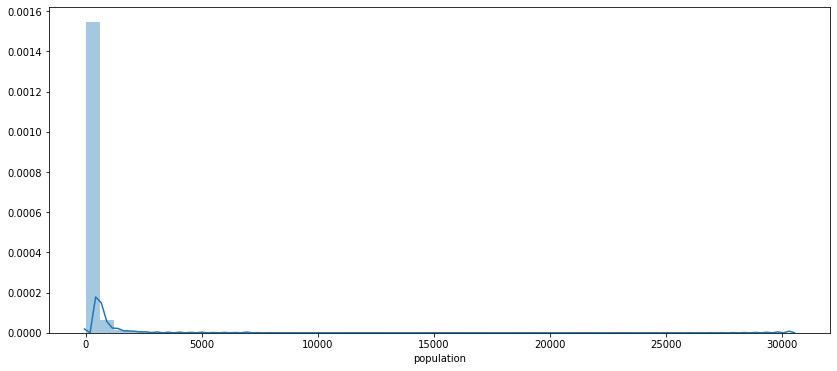

In [19]:
"""
The 'population' and the 'amount_tsh' distribution is the same, and they are left skewed. Decision trees are robust for skewed
data, but others aren't.

"As a general rule of thumb: 
If skewness is less than -1 or greater than 1, the distribution is highly skewed. 
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. 
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric."
"""

plt.figure(figsize=(14, 6))
sns.distplot(data['population'])

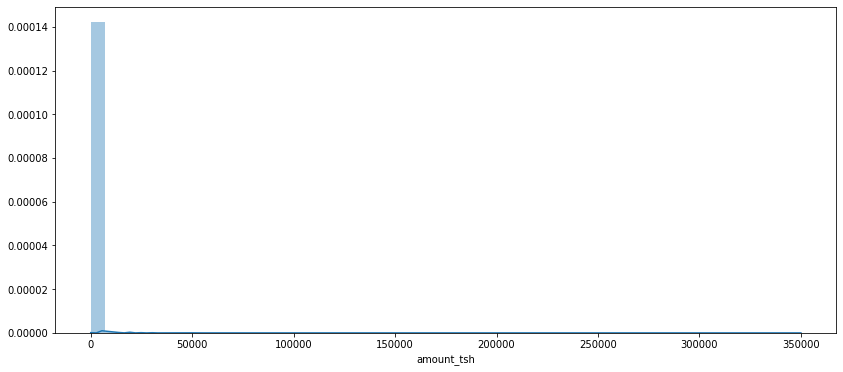

In [20]:
plt.figure(figsize=(14, 6))
sns.distplot(data['amount_tsh'])

In [21]:
"""
Pandas' use the Fisher–Pearson standardized moment coefficient.

https://medium.com/@ODSC/transforming-skewed-data-for-machine-learning-90e6cc364b0
"""

print(data['population'].skew())
print(data['amount_tsh'].skew())

12.660713588843592
57.8077999458852


In [22]:
"""
Log transformation decreased the skewness. I added 1 to every value, because it couldn't handle 0 values. 

Only changing the original columns to these made a percent worse accuracy.
"""

data['logt_population'] = np.log(data['population'] + 1)
data['logt_amounttsh'] = np.log(data['amount_tsh'] + 1)

print(data['logt_population'].skew())
print(data['logt_amounttsh'].skew())

0.1414983993018132
1.3370903407288008


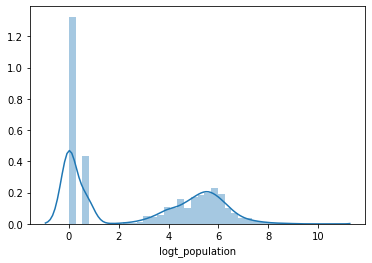

In [23]:
sns.distplot(data['logt_population'])

# Creating the train / test / validation sets

In [24]:
"""
Original, without log transformed amount_tsh and population columns.
"""

data_selected = data[['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'num_private', 'basin',
                    'region_code', 'district_code', 'population', 'public_meeting', 'scheme_management', 'permit',
                    'construction_year', 'extraction_type_class', 'payment_type', 'quality_group', 'quantity', 'source_type',
                    'source_class', 'waterpoint_type_group', 'label']]

In [25]:
"""
Read the test data, and make the conversions. 
"""

test = pd.read_csv('https://raw.githubusercontent.com/budapestpy-workshops/workshops/master/09_pump_it_up/Test_set_values.csv')

test['funder'] = test.apply(lambda row: funder_binning(row), axis=1)
test['installer'] = test.apply(lambda row: installer_binning(row), axis=1)
test['scheme_management'] = test.apply(lambda row: scheme_management_binning(row), axis=1)

test['subvillage'] = test['subvillage'].fillna(test['subvillage'].mode().iloc[0])

test['public_meeting'].fillna(False, inplace=True)
test['permit'].fillna(False, inplace=True)

test['logt_population'] = np.log(data['population'] + 1)
test['logt_amounttsh'] = np.log(data['amount_tsh'] + 1)

test['construction_year'] = test.apply(lambda row: construction_year_binning(row), axis=1)

In [26]:
dummy_cols = ['funder', 'installer', 'basin', 'public_meeting', 'scheme_management', 'permit',
              'construction_year', 'extraction_type_class', 'payment_type', 'quality_group',
              'quantity', 'source_type', 'source_class', 'waterpoint_type_group']

data_selected = pd.get_dummies(data_selected, columns=dummy_cols, drop_first=True)
data_selected.shape

(59400, 74)

In [27]:
data_selected.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,label,funder_gov,funder_hesawa,funder_other,funder_rwssp,funder_worldbank,installer_danida,installer_dwe,installer_gov,installer_other,installer_rwe,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,...,payment_type_other,payment_type_per bucket,payment_type_unknown,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_surface,source_class_unknown,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,6000.0,1390,34.938093,-9.856322,0,11,5,109,2,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,0.0,1399,34.698766,-2.147466,0,20,2,280,2,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
2,25.0,686,37.460664,-3.821329,0,21,4,250,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
3,0.0,263,38.486161,-11.155298,0,90,63,58,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.0,0,31.130847,-1.825359,0,18,1,0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0


In [28]:
"""
Original, without log transformed amount_tsh and population columns.
"""

test_selected = test[['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'num_private', 'basin',
            'region_code', 'district_code', 'population', 'public_meeting', 'scheme_management', 'permit',
            'construction_year', 'extraction_type_class', 'payment_type', 'quality_group', 'quantity', 'source_type',
            'source_class', 'waterpoint_type_group']]

test_selected = pd.get_dummies(test_selected, columns=dummy_cols, drop_first=True)
test_selected.shape

(14850, 73)

In [29]:
target = data_selected['label']
features = data_selected.drop('label', axis=1)

In [30]:
"""
Creating the train / test / validation datasets.
"""

X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, stratify=target)
print('X_train original shape:', X_train.shape)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.85, stratify=y_train)
print('X_train shape after creating validation set:', X_train.shape)
print('X_val shape:', X_val.shape)

X_train original shape: (47520, 73)
X_train shape after creating validation set: (40392, 73)
X_val shape: (7128, 73)


# Modeling

### Experimenting with PCA

### XGBoost

In [31]:
"""
1 - Untuned XGBoost: objective='multi:softmax', eval_metric='merror', num_class=3, 73.9% DrivenData score
2 - Tuned: eta=0.01, max_depth=3, min_child_weight=0, n_estimators=200, scale_pos_weigth=9,
    objective='multi:softmax', eval_metric='merror', num_class=3, 75.2% DrivenData score
3 - With 30 components PCA (dimension reduction from ~120 columns to 30), and cross-validation, 72%. I didn't submit 
    it to DrivenData, because you have 3 submissions per day, I'm just experimenting.
"""
# sima eta=0.01, max_depth=3, min_child_weight=0, n_estimators=200, scale_pos_weigth=9,

xgboost_classifier = XGBClassifier(eta=0.01, max_depth=3, min_child_weight=0, n_estimators=200, scale_pos_weigth=5,
                                   objective='multi:softmax', eval_metric='merror', num_class=3)

xgboost = xgboost_classifier.fit(X_train, y_train.values.ravel())

expected = y_test
predicted = xgboost.predict(X_test)

print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73      4565
           1       0.62      0.11      0.19       863
           2       0.73      0.92      0.81      6452

    accuracy                           0.76     11880
   macro avg       0.73      0.56      0.58     11880
weighted avg       0.76      0.76      0.74     11880



In [ ]:
"""
Testing the validation set, which is unseen for the model.
"""

validation_expected = y_val
validation_predicted = xgboost.predict(X_val)

print(metrics.classification_report(validation_expected, validation_predicted))

In [ ]:
"""
Get feature importances.
Of course, this works without PCA, so when we know the original columns.

"The Gain is the most relevant attribute to interpret the relative importance of each feature."
"""

xgb_fi = xgboost.get_booster().get_score(importance_type="gain")

xgboost_feature_importances = pd.DataFrame(list(xgb_fi.items()), columns=['feature_name', 'importance'])

xgboost_feature_importances.sort_values(by=['importance'], ascending=False).head(10)

In [ ]:
"""
GridSearchCV, the most computation expensive part of the process. With a relatively small amount of parameters, it lifted
the performance from 73.9% to 75.2%.
"""

params = {'n_estimators': [50, 100, 200],
          'max_depth': [3, 5, 8],
          'eta': [0.01, 0.05, 0.1, 0.2],
          'min_child_weight': [0, 1, 3],
          'scale_pos_weigth': [1, 5, 9]
         }

grid_search = GridSearchCV(estimator=xgboost, cv=5, param_grid=params, verbose=10)

grid_search.fit(X_train, y_train.values.ravel())

print(grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
"""
Cross validation took about 5 minutes, and it showed a 74% accuracy. We can see each fold, the model is straight, because
it keeps bringing the same result.
"""

scores = cross_val_score(xgboost, X_train, y_train, cv=5, verbose=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### Random Forest

In [32]:
clf = ensemble.RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=2)
clf = clf.fit(X_train, y_train)

expected = y_test
predicted = clf.predict(X_test)

print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.85      0.62      0.72      4565
           1       0.68      0.04      0.08       863
           2       0.71      0.94      0.81      6452

    accuracy                           0.75     11880
   macro avg       0.75      0.53      0.54     11880
weighted avg       0.76      0.75      0.72     11880



In [ ]:
params = {'n_estimators' : [10, 50, 200],
          'min_samples_split' : [2, 3, 4],
          'max_depth': [3, 5, 8, 10]}

grid_search = GridSearchCV(estimator=clf, cv=3, param_grid=params, verbose=10)

grid_search.fit(X_train, y_train.values.ravel())

print(grid_search.best_score_)
print(grid_search.best_params_)

### SVM

"""
SVM clearly not the best fit for this problem, because of the 100+ columns.
"""

svc = svm.SVC()
svc = svc.fit(X_train, y_train)

expected = y_test
predicted = svc.predict(X_test)

print(metrics.classification_report(expected, predicted))

### Logistic regression

In [40]:
"""

"""

logreg = LogisticRegression(multi_class='auto', solver='newton-cg', max_iter=50)
logreg.fit(X_train, y_train)

expected = y_test
predicted = logreg.predict(X_test)

print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.79      0.62      0.69      4565
           1       0.42      0.03      0.05       863
           2       0.71      0.90      0.79      6452

    accuracy                           0.73     11880
   macro avg       0.64      0.52      0.51     11880
weighted avg       0.72      0.73      0.70     11880



C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [39]:
"""
GridSearch
"""

params = {'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
          'max_iter': [50, 150, 200]
         }

grid_search = GridSearchCV(estimator=logreg, cv=5, param_grid=params, verbose=10)

grid_search.fit(X_train, y_train.values.ravel())

print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_iter=50, solver=newton-cg ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.

[CV] ....... max_iter=50, solver=newton-cg, score=0.732, total=  40.4s
[CV] max_iter=50, solver=newton-cg ...................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence t

[CV] ....... max_iter=50, solver=newton-cg, score=0.729, total= 1.0min
[CV] max_iter=50, solver=newton-cg ...................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min remaining:    0.0s
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence t

[CV] ....... max_iter=50, solver=newton-cg, score=0.727, total=  29.6s
[CV] max_iter=50, solver=newton-cg ...................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.7min remaining:    0.0s
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence t

[CV] ....... max_iter=50, solver=newton-cg, score=0.725, total=  31.2s
[CV] max_iter=50, solver=newton-cg ...................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.2min remaining:    0.0s
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence t

[CV] ....... max_iter=50, solver=newton-cg, score=0.721, total=  27.3s
[CV] max_iter=50, solver=sag .........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............. max_iter=50, solver=sag, score=0.541, total=  10.0s
[CV] max_iter=50, solver=sag .........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.3min remaining:    0.0s
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............. max_iter=50, solver=sag, score=0.537, total=  11.0s
[CV] max_iter=50, solver=sag .........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.5min remaining:    0.0s
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............. max_iter=50, solver=sag, score=0.538, total=  10.3s
[CV] max_iter=50, solver=sag .........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.7min remaining:    0.0s
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............. max_iter=50, solver=sag, score=0.538, total=  11.6s
[CV] max_iter=50, solver=sag .........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.9min remaining:    0.0s
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............. max_iter=50, solver=sag, score=0.537, total=  12.6s
[CV] max_iter=50, solver=saga ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=50, solver=saga, score=0.540, total=  11.5s
[CV] max_iter=50, solver=saga ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=50, solver=saga, score=0.536, total=  12.8s
[CV] max_iter=50, solver=saga ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=50, solver=saga, score=0.537, total=  16.8s
[CV] max_iter=50, solver=saga ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=50, solver=saga, score=0.538, total=  16.0s
[CV] max_iter=50, solver=saga ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=50, solver=saga, score=0.537, total=  18.0s
[CV] max_iter=50, solver=lbfgs .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\ana

[CV] ........... max_iter=50, solver=lbfgs, score=0.587, total=   2.2s
[CV] max_iter=50, solver=lbfgs .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ........... max_iter=50, solver=lbfgs, score=0.567, total=   2.3s
[CV] max_iter=50, solver=lbfgs .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ........... max_iter=50, solver=lbfgs, score=0.547, total=   2.3s
[CV] max_iter=50, solver=lbfgs .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ........... max_iter=50, solver=lbfgs, score=0.617, total=   2.4s
[CV] max_iter=50, solver=lbfgs .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ........... max_iter=50, solver=lbfgs, score=0.569, total=   2.2s
[CV] max_iter=150, solver=newton-cg ..................................
[CV] ...... max_iter=150, solver=newton-cg, score=0.732, total= 1.1min
[CV] max_iter=150, solver=newton-cg ..................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ...... max_iter=150, solver=newton-cg, score=0.729, total= 1.0min
[CV] max_iter=150, solver=newton-cg ..................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ...... max_iter=150, solver=newton-cg, score=0.727, total= 1.1min
[CV] max_iter=150, solver=newton-cg ..................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ...... max_iter=150, solver=newton-cg, score=0.726, total= 1.2min
[CV] max_iter=150, solver=newton-cg ..................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ...... max_iter=150, solver=newton-cg, score=0.720, total= 1.8min
[CV] max_iter=150, solver=sag ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=150, solver=sag, score=0.540, total=  53.3s
[CV] max_iter=150, solver=sag ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=150, solver=sag, score=0.535, total=  43.4s
[CV] max_iter=150, solver=sag ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=150, solver=sag, score=0.539, total=  45.8s
[CV] max_iter=150, solver=sag ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=150, solver=sag, score=0.541, total=  33.8s
[CV] max_iter=150, solver=sag ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=150, solver=sag, score=0.535, total=  34.7s
[CV] max_iter=150, solver=saga .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........... max_iter=150, solver=saga, score=0.542, total=  44.0s
[CV] max_iter=150, solver=saga .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........... max_iter=150, solver=saga, score=0.535, total=  44.6s
[CV] max_iter=150, solver=saga .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........... max_iter=150, solver=saga, score=0.539, total=  44.0s
[CV] max_iter=150, solver=saga .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........... max_iter=150, solver=saga, score=0.539, total=  35.9s
[CV] max_iter=150, solver=saga .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........... max_iter=150, solver=saga, score=0.537, total=  44.3s
[CV] max_iter=150, solver=lbfgs ......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\ana

[CV] .......... max_iter=150, solver=lbfgs, score=0.681, total=   7.2s
[CV] max_iter=150, solver=lbfgs ......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] .......... max_iter=150, solver=lbfgs, score=0.670, total=   7.2s
[CV] max_iter=150, solver=lbfgs ......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] .......... max_iter=150, solver=lbfgs, score=0.672, total=   6.4s
[CV] max_iter=150, solver=lbfgs ......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] .......... max_iter=150, solver=lbfgs, score=0.668, total=   6.6s
[CV] max_iter=150, solver=lbfgs ......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] .......... max_iter=150, solver=lbfgs, score=0.666, total=   7.7s
[CV] max_iter=200, solver=newton-cg ..................................
[CV] ...... max_iter=200, solver=newton-cg, score=0.732, total= 1.1min
[CV] max_iter=200, solver=newton-cg ..................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ...... max_iter=200, solver=newton-cg, score=0.729, total= 1.0min
[CV] max_iter=200, solver=newton-cg ..................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ...... max_iter=200, solver=newton-cg, score=0.727, total= 1.2min
[CV] max_iter=200, solver=newton-cg ..................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ...... max_iter=200, solver=newton-cg, score=0.726, total= 1.2min
[CV] max_iter=200, solver=newton-cg ..................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ...... max_iter=200, solver=newton-cg, score=0.720, total= 1.3min
[CV] max_iter=200, solver=sag ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=200, solver=sag, score=0.540, total=  51.1s
[CV] max_iter=200, solver=sag ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=200, solver=sag, score=0.534, total=  48.4s
[CV] max_iter=200, solver=sag ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=200, solver=sag, score=0.540, total= 1.0min
[CV] max_iter=200, solver=sag ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=200, solver=sag, score=0.538, total=  53.8s
[CV] max_iter=200, solver=sag ........................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............ max_iter=200, solver=sag, score=0.536, total=  51.8s
[CV] max_iter=200, solver=saga .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........... max_iter=200, solver=saga, score=0.542, total=  52.3s
[CV] max_iter=200, solver=saga .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........... max_iter=200, solver=saga, score=0.535, total=  54.1s
[CV] max_iter=200, solver=saga .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........... max_iter=200, solver=saga, score=0.539, total=  51.6s
[CV] max_iter=200, solver=saga .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........... max_iter=200, solver=saga, score=0.539, total=  48.1s
[CV] max_iter=200, solver=saga .......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........... max_iter=200, solver=saga, score=0.537, total=  47.8s
[CV] max_iter=200, solver=lbfgs ......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\ana

[CV] .......... max_iter=200, solver=lbfgs, score=0.690, total=   7.8s
[CV] max_iter=200, solver=lbfgs ......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] .......... max_iter=200, solver=lbfgs, score=0.676, total=   7.7s
[CV] max_iter=200, solver=lbfgs ......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] .......... max_iter=200, solver=lbfgs, score=0.680, total=   8.6s
[CV] max_iter=200, solver=lbfgs ......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] .......... max_iter=200, solver=lbfgs, score=0.681, total=   7.9s
[CV] max_iter=200, solver=lbfgs ......................................


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 34.5min finished
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this w

[CV] .......... max_iter=200, solver=lbfgs, score=0.689, total=   8.3s


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


0.7267775797187562
{'max_iter': 50, 'solver': 'newton-cg'}


C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [35]:
from sklearn.ensemble import VotingClassifier

estimators=[('xgboost', xgboost), ('random_forest', clf), ('logreg', logreg)]

ensemble = VotingClassifier(estimators, voting='hard')

In [36]:
ensemble.fit(X_train, y_train)

ensemble.score(X_test, y_test)

C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7463804713804714

### Create the submission

In [37]:
"""
The 'status_group_nums' should be changed with the model we want to predict.
"""

submission = pd.read_csv('https://raw.githubusercontent.com/budapestpy-workshops/workshops/master/09_pump_it_up/SubmissionFormat.csv')
submission['status_group_nums'] = ensemble.predict(test_selected)

label_dict = {2: "functional", 1: "functional needs repair", 0 :"non functional"}
submission["status_group"] = submission["status_group_nums"].map(label_dict)
submission = submission.drop('status_group_nums', axis=1)

submission.to_csv('pumpitup.csv',index=False)

submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 2 columns):
id              14850 non-null int64
status_group    14850 non-null object
dtypes: int64(1), object(1)
memory usage: 232.2+ KB


In [ ]:
submission.head()

### Notes

In [ ]:
"""
DataCamp: Feature engineering with Python course:

One-hot and dummy encoding, drop_first=True, because if not specified the model could be distracted by duplicate info.
Numerical columns: binning with pd.cut, so if we have ten different values in a column, but three of them are the 70% of all,
the other 7 could be "other".

Scaling: StandardScaler does not affect the data's shape. This works great if your data is normally distributed 
(or closely normally distributed), an assumption that a lot of machine learning models make. Sometimes you will work 
with data that closely conforms to normality, e.g the height or weight of a population. On the other hand, many variables 
in the real world do not follow this pattern e.g, wages or age of a population. In this exercise you will use a log 
transform on the ConvertedSalary column as it has a large amount of its data centered around the lower values, 
but contains very high values also. These distributions are said to have a long right tail.
We should try the PowerTransformer for these kind of columns.

Though Tree based models won't affect by the standardization.

Fit and transform on the TRAINING data, and ONLY TRANSFORM on the TEST data. This is to avoid data leakage, because in real life
we won't have access to test data, so we have to work with what we have, when making the model. Calibrate the preprocessing
steps only on the training data. To do this in practice you train the scaler on the train set, and keep the trained scaler 
to apply it to the test set. You should never retrain a scaler on the test set. This approach is for scaling, and for removing
outilers too.

I should check the distributions of the columns to look fo outliers. Eliminate data with 3 std
(this is the more statistical approach), or the 95th quantile (column.quantile(0.95)).

More:

- VotingClassifier check. https://towardsdatascience.com/ensemble-learning-using-scikit-learn-85c4531ff86a
    74.5% but the Logistic regression, the third model may not be the best choice.

- 'construction_year' binning. Check out the earliest, and the latest dates. - This made from 75.20% to 75.25%. 
   Very small step, but helped.
   
- Dimension reduction - needs scaling first. Try with just scaling, and then with scaling and PCA. - 
  It didn't helped for first try.
  
- 'functional needs repair' oversampling

- DL soluiton

- log transformation - done, 74.55% was the driven data accuracy, on my validation set, it was 75% so it was 1% better. 

- perc_func_lga



"""

In [43]:
import imblearn

ImportError: cannot import name '_safe_indexing' from 'sklearn.utils' (C:\Users\bbalogh7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\__init__.py)